In [1]:
import numpy as np
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pathlib import Path
from numpy import linalg as LA
from sklearn.base import BaseEstimator
from tqdm import trange
import pandas as pd
import pickle
import os

In [2]:
import matplotlib.pyplot as plt

In [3]:
from scipy import stats

In [4]:
from sklearn.linear_model import ElasticNet

In [5]:
def make_singular(n, p, rng=0, noise=0.001,radius=1):

    #matrix A
    singular_part=int(p/5)
    rng = np.random.default_rng(rng)
    A = rng.normal(size=(p, n))
    A[0:singular_part,:]=50*rng.normal(size=(singular_part,n))
    preprocess = StandardScaler()
    A = preprocess.fit_transform(A)
    A=radius*np.transpose(A)/np.sqrt(p)

    #hidden x
    x = np.zeros(p)
    x[0:singular_part] = 3
    b = A @ x + noise*rng.normal(size=n)


    return A, b, x


In [6]:
def lasso_obj(A, b, x, c1,c2):
    return (LA.norm(A @ x - b))**2/A.shape[0] + c1 * LA.norm(x, ord=1)+c2*(LA.norm(x,ord=2))**2



In [7]:
class MyADMM(BaseEstimator):
    def __init__(self,
    beta=0.14418361364211363,
    eta=1,
    max_iter=100,
    scale_noise=0,
    n=1000,
    p=64,
    rng=0,
    nu=1,
    mu=1,
    mu_g=1,
    L = 1) -> None:
        self.max_iter = max_iter
        self.beta=beta
        self.eta=eta
        self.scale_noise = scale_noise
        self.eta=eta
        self.rng = np.random.default_rng(rng)
        self.L=L
        self.n = n
        self.p = p
        self.scores=[]
        self.avg_scores=[]

    def estimate_parameter(self, radius, c1, c2, beta=1,scale_noise=0.001):

        #smoothness and convex parameters
        self.nu=2*(radius**2)
        self.mu=2*(radius**2)
        self.mu_g=2*c2
        self.beta=beta
        self.scale_noise=scale_noise

        #estimate eta
        L_1=4/(self.mu+self.nu+np.sqrt((self.nu+self.mu)**2+8*self.nu*self.mu))
        L_2=2/(self.nu+self.mu)-2*self.mu_g/(self.beta**2)
        U=2/(self.nu+self.mu)

        if L_1>L_2:
            self.eta=(L_1+U)/2
        else:
            self.eta=(L_2+U)/2
        #self.max_iter=int(1/(self.eta**2))

        #estimate L
        R=(1-2*self.eta*self.nu*self.mu/(self.nu+self.mu))+(2/(self.nu+self.mu)-self.eta)/self.eta
        S=self.eta/self.beta
        Q=S+self.eta*(2/(self.nu+self.mu)-self.eta)/4
        P=1-(2/(self.nu+self.mu)-self.eta)/self.eta
        self.L=max(R/P,S/Q)




    def fit(self, A, b, c1,c2):

        self.x=3*np.ones(self.p)
        #print(self.x)

        self.y = self.x*0
        self.lamb = np.zeros(self.p)

        scores = []
        scores.append(lasso_obj(A, b, self.x, c1,c2))


        for it in trange(self.max_iter, leave=False):

            #update for y
            for i in range(len(self.y)):
                if self.lamb[i]-self.beta*self.x[i]+c1>0 and self.lamb[i]-self.beta*self.x[i]-c1<0:
                    self.y[i]=0
                elif self.lamb[i]-self.beta*self.x[i]+c1>0 and self.lamb[i]-self.beta*self.x[i]-c1>0:
                    self.y[i]=-(self.lamb[i]-self.beta*self.x[i]-c1)/(2*c2+self.beta)
                elif self.lamb[i]-self.beta*self.x[i]+c1<0 and self.lamb[i]-self.beta*self.x[i]-c1<0:
                    self.y[i]=-(self.lamb[i]-self.beta*self.x[i]+c1)/(2*c2+self.beta)
                else:
                    if (self.lamb[i]-self.beta*self.x[i]+c1)**2>(self.lamb[i]-self.beta*self.x[i]-c1)**2:
                        self.y[i]=-(self.lamb[i]-self.beta*self.x[i]+c1)/(2*c2+self.beta)
                    else:
                        self.y[i]=-(self.lamb[i]-self.beta*self.x[i]-c1)/(2*c2+self.beta)

            #udate for lambda
            self.lamb=self.lamb-self.beta*(self.x-self.y)


            #update for x
            index=self.rng.integers(A.shape[0])
            sample_a=np.transpose(A[index,:])
            sample_b=b[index]
            nabla_f=2*(np.dot(sample_a,self.x)-sample_b)*sample_a
            self.x=(self.x-self.eta*(nabla_f-self.beta*self.y-self.lamb))/(1+self.eta*self.beta)

            self.x=self.x+self.scale_noise*self.rng.normal(size=p)




            #save data
            scores.append(lasso_obj(A, b, self.x, c1,c2))

        self.scores = np.array(scores)

    def multiple_time_fit(self, A, b, c1,c2,stime=100):
        self.scores_multi_run=np.zeros([stime,self.max_iter+1])
        self.avg_scores=np.zeros(self.max_iter+1)
        for i in range(stime):
            self.fit(A,b,c1,c2)
            self.scores_multi_run[i,:]=self.scores
            self.avg_scores=self.avg_scores+self.scores/stime




In [8]:
n = 1000
p = 64
support=32
c1=0.01
c2=0.1

noise=0.01

In [9]:
#######################
# Run ADMM in different L
#######################

Record_on_differen_L=[]
Record_multi_run_L=[]

admm_L = MyADMM()


In [10]:
r = 0.5
beta=0.9

A, b, true_x = make_singular(n, p, rng=18,noise=0.01,radius=r)

admm_L.estimate_parameter(r,c1,c2,beta,0)
admm_L.eta=0.1
print(admm_L.eta)

admm_L.fit(A,b,c1,c2)
opt=min(admm_L.scores)
print(opt)

admm_L.estimate_parameter(r,c1,c2,beta,noise)
print(admm_L.L)
admm_L.multiple_time_fit(A,b,c1,c2)
Record_on_differen_L.append((admm_L.L,admm_L.avg_scores-opt))
Record_multi_run_L.append(admm_L.scores_multi_run)

0.1


2.811985325014982
0.9473684210526315


In [11]:
r = 0.3
beta=0.5

A, b, true_x = make_singular(n, p, rng=18,noise=0.01,radius=r)

admm_L.estimate_parameter(r,c1,c2,beta,0)
admm_L.eta=0.1
print(admm_L.eta)

admm_L.fit(A,b,c1,c2)
opt=min(admm_L.scores)
print(opt)

admm_L.estimate_parameter(r,c1,c2,beta,noise)
print(admm_L.L)
admm_L.multiple_time_fit(A,b,c1,c2)
Record_on_differen_L.append((admm_L.L,admm_L.avg_scores-opt))
Record_multi_run_L.append(admm_L.scores_multi_run)

0.1


1.800782420961521
0.9148813478072089


In [12]:
r = 0.15
beta=0.3

A, b, true_x = make_singular(n, p, rng=18,noise=0.01,radius=r)

admm_L.estimate_parameter(r,c1,c2,beta,0)
admm_L.eta=0.1
print(admm_L.eta)

admm_L.fit(A,b,c1,c2)
opt=min(admm_L.scores)
print(opt)

admm_L.estimate_parameter(r,c1,c2,beta,noise)
print(admm_L.L)
admm_L.multiple_time_fit(A,b,c1,c2)
Record_on_differen_L.append((admm_L.L,admm_L.avg_scores-opt))
Record_multi_run_L.append(admm_L.scores_multi_run)

0.1


1.3125600997928328
0.8571428571428573


In [13]:
r = 0.1
beta=0.15

A, b, true_x = make_singular(n, p, rng=18,noise=0.01,radius=r)
admm_L.estimate_parameter(r,c1,c2,beta,0)
admm_L.eta=0.1
print(admm_L.eta)

admm_L.fit(A,b,c1,c2)
opt=min(admm_L.scores)
print(opt)

admm_L.estimate_parameter(r,c1,c2,beta,0)
print(admm_L.L)
admm_L.multiple_time_fit(A,b,c1,c2)
Record_on_differen_L.append((admm_L.L,admm_L.avg_scores-opt))
Record_multi_run_L.append(admm_L.scores_multi_run)

0.1


1.1418022238549461
0.799231224022575


In [14]:
confidence_level=0.05

In [15]:
convergence_step=[]
for i in range(len(Record_multi_run_L)):
  for j in range(len(Record_multi_run_L[0][0,:])-5):
    test1=stats.levene(Record_multi_run_L[i][:,j], Record_multi_run_L[i][:,j+5])
    if(test1.pvalue>0.2):
      test2=stats.ttest_ind(Record_multi_run_L[i][:,j], Record_multi_run_L[i][:,j+5],equal_var=True)
    else:
      test2=stats.ttest_ind(Record_multi_run_L[i][:,j], Record_multi_run_L[i][:,j+5],equal_var=False)
    if(test2.pvalue/2>confidence_level):
      convergence_step.append(j)
      break

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


In [16]:
convergence_step

[26, 13, 7, 6]

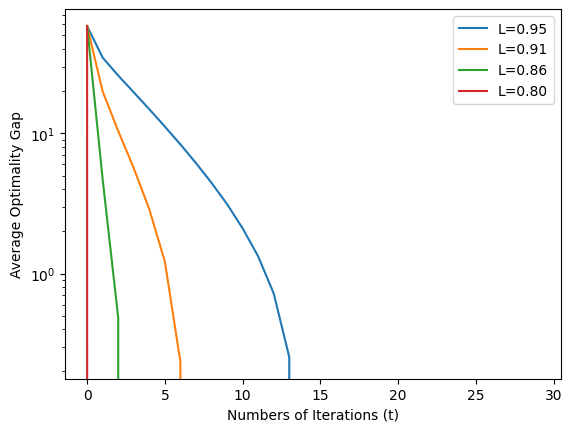

In [ ]:
figure,ax=plt.subplots()
plt.yscale('log')
for i in range(len(Record_on_differen_L)):
    ax.plot(Record_on_differen_L[i][1][0:30],label='L=%.2f'%Record_on_differen_L[i][0])
ax.legend()
plt.xlabel("Numbers of Iterations (t)")
plt.ylabel("Average Optimality Gap")
plt.plot()


plt.savefig('L_log.pdf',format='pdf')



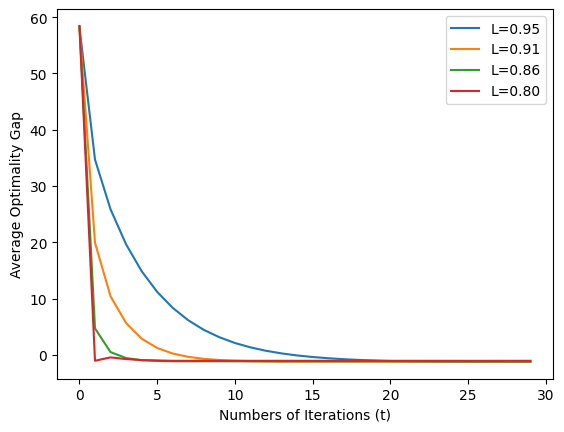

In [ ]:
figure,ax=plt.subplots()
#plt.yscale('log')
for i in range(len(Record_on_differen_L)):
    ax.plot(Record_on_differen_L[i][1][0:30],label='L=%.2f'%Record_on_differen_L[i][0])
ax.legend()
plt.xlabel("Numbers of Iterations (t)")
plt.ylabel("Average Optimality Gap")
plt.plot()


plt.savefig('L.pdf',format='pdf')



In [ ]:
#######################
# Run ADMM in different sigma
#######################

Record_on_differen_sigma=[]

admm_sigma = MyADMM()
Record_multi_run_sigma=[]


In [ ]:
n = 1000
p = 64
support=32
c1=0.01
c2=0.1
r = 0.5
beta=0.9
A, b, true_x = make_singular(n, p, rng=18,noise=0.01,radius=r)

In [ ]:
admm_sigma.estimate_parameter(r,c1,c2,beta,0)
admm_sigma.fit(A,b,c1,c2)
opt=min(admm_sigma.scores)
print(opt)

1.4330115236248464


In [ ]:
print(admm_sigma.eta)

1.7530864197530864


In [ ]:
scale_noise=0.05

admm_sigma.estimate_parameter(r,c1,c2,beta,scale_noise)
print(admm_sigma.L)
admm_sigma.multiple_time_fit(A,b,c1,c2)
Record_on_differen_sigma.append((admm_sigma.scale_noise,admm_sigma.avg_scores-opt))
Record_multi_run_sigma.append(admm_sigma.scores_multi_run)

0.9473684210526315


In [ ]:
scale_noise=0.1

admm_sigma.estimate_parameter(r,c1,c2,beta,scale_noise)
print(admm_sigma.L)
admm_sigma.multiple_time_fit(A,b,c1,c2)
Record_on_differen_sigma.append((admm_sigma.scale_noise,admm_sigma.avg_scores-opt))
Record_multi_run_sigma.append(admm_sigma.scores_multi_run)

0.9473684210526315


In [ ]:
scale_noise=0.2

admm_sigma.estimate_parameter(r,c1,c2,beta,scale_noise)
print(admm_sigma.L)
admm_sigma.multiple_time_fit(A,b,c1,c2)
Record_on_differen_sigma.append((admm_sigma.scale_noise,admm_sigma.avg_scores-opt))
Record_multi_run_sigma.append(admm_sigma.scores_multi_run)

0.9473684210526315


In [ ]:
scale_noise=0.5

admm_sigma.estimate_parameter(r,c1,c2,beta,scale_noise)
print(admm_sigma.L)
admm_sigma.multiple_time_fit(A,b,c1,c2)
Record_on_differen_sigma.append((admm_sigma.scale_noise,admm_sigma.avg_scores-opt))
Record_multi_run_sigma.append(admm_sigma.scores_multi_run)

0.9473684210526315


In [ ]:
scale_noise=0.7

admm_sigma.estimate_parameter(r,c1,c2,beta,scale_noise)
admm_sigma.eta=5
print(admm_sigma.L)
admm_sigma.multiple_time_fit(A,b,c1,c2)
Record_on_differen_sigma.append((admm_sigma.scale_noise,admm_sigma.avg_scores-opt))
Record_multi_run_sigma.append(admm_sigma.scores_multi_run)

0.9473684210526315


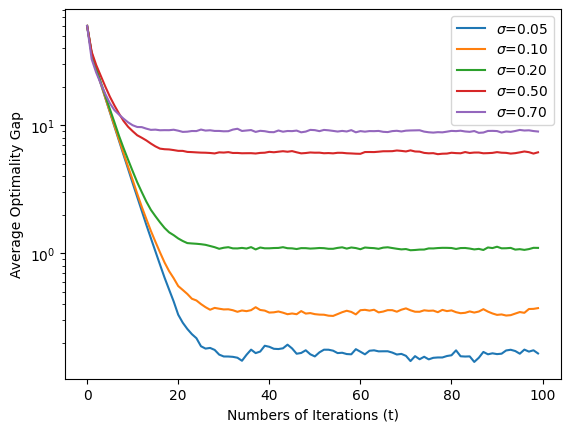

In [ ]:
figure,ax=plt.subplots()
plt.yscale('log')
for i in range(len(Record_on_differen_sigma)):
    ax.plot(Record_on_differen_sigma[i][1][0:100],label='$\sigma$=%.2f'%Record_on_differen_sigma[i][0])
ax.legend()
plt.xlabel("Numbers of Iterations (t)")
plt.ylabel("Average Optimality Gap")
plt.plot()

plt.savefig('sigma_log.pdf',format='pdf')


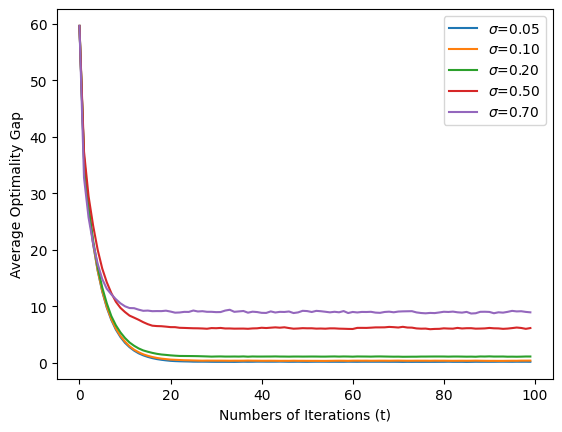

In [ ]:
figure,ax=plt.subplots()
#plt.yscale('log')
for i in range(len(Record_on_differen_sigma)):
    ax.plot(Record_on_differen_sigma[i][1][0:100],label='$\sigma$=%.2f'%Record_on_differen_sigma[i][0])
ax.legend()
plt.xlabel("Numbers of Iterations (t)")
plt.ylabel("Average Optimality Gap")
plt.plot()
plt.savefig('sigma.pdf',format='pdf')


In [ ]:
confidence_level=0.05

In [ ]:
p_value_sigma=np.zeros([5,5])
for i in range(len(Record_multi_run_sigma)):
  for j in range(len(Record_multi_run_sigma)):
    test1=stats.levene(Record_multi_run_sigma[i][:,-1], Record_multi_run_sigma[j][:,-1])
    #print(test1.pvalue)
    if(test1.pvalue>confidence_level):
      test2=stats.ttest_ind(Record_multi_run_sigma[i][:,-1], Record_multi_run_sigma[j][:,-1],equal_var=True)
    else:
      test2=stats.ttest_ind(Record_multi_run_sigma[i][:,-1], Record_multi_run_sigma[j][:,-1],equal_var=False)

    p_value_sigma[i,j]=test2.pvalue

In [ ]:
print(p_value_sigma)

[[1.00000000e+00 4.19735117e-27 1.87307327e-71 4.56834001e-78
  2.29504823e-79]
 [4.19735117e-27 1.00000000e+00 3.28998168e-62 4.12355945e-77
  1.11259415e-78]
 [1.87307327e-71 3.28998168e-62 1.00000000e+00 6.69671947e-74
  2.21838923e-76]
 [4.56834001e-78 4.12355945e-77 6.69671947e-74 1.00000000e+00
  1.83075702e-36]
 [2.29504823e-79 1.11259415e-78 2.21838923e-76 1.83075702e-36
  1.00000000e+00]]
